# Case Study: 27th June 2022

The following assignment should:
- give you a sense of forecast uncertainty in a HRRR forecast
- motivate the point of pursuing machine learning as a proof-of-concept in the first place
- give you code templates to use during the main paper writing

## Take-home assignment
You should log onto joanne, and first activate the anaconda environment for this class:

```
conda activate class496_fall22

```

Answer the following questions and justify your logic both in English and Python coding/commenting:

1. Give a weather-briefing-style synoptic overview of the day from 06Z (27th) to 06Z (28th). Use the "forecast funnel" approach to zoom into Chicago to contexualise this case, keeping in mind lessons learnt from the recent Crosman and Horel paper (e.g., why is the large-scale wind important to know?). Refer where appropriate to published papers, textbooks, etc. For this question, **create a simple set of slides (e.g., a PowerPoint or PDF) and upload this separately**. Caleb should have at least six slides; Noah a minimum of three. There are various archives around the internet of satellite, radar, surface analyses, etc.; you may even want to plot some data from the HRRR model (0-hour forecasts and/or analyses) itself using the assignment code as a template...
2. Produce at least three (Noah)/five (Caleb) further visualisations, not including those you may have shown above, that demonstrate key characteristics of the case (forecast differences, structure, etc). Have some fun with visualisations you make! Think about whether it's possible to plot various variables, levels, times, data sources. How about cross-sections or other viewpoints? Don't worry if you can't do everything: the HRRR data is very difficult to use with existing packages, as you can see. As in a paper, you can't show everything, so what carries most weight for supporting your argument?
3. Make hypotheses drawn from your data analysis and visualisations about elements that were poorly or well forecast. Noah, concentrate on either O'Hare or Midway. Caleb, I expect you to __go further__ in your discussion whilst look at all three airport stations.
4. Ignoring the case's specific synoptic pattern for a minute, comment on how this event relates the time of day and year, and contrast with Laird __et al.__ (2001). Caleb, go further and find at least two other sources discussing climatology of LBFs, then compare this with our case.

Bonus credits on offer for code improvements, because no one is perfect, __especially__ code written by this instructor. Make sure you document any code changes with a comment and your initials (e.g., `# JRL: I used a faster function here.`). Add new code in its own block and document either in-line in the code, or as a Markdown cell. Due to credit differences, I expect Caleb to think more about coding efficiency, regardless of extra credit.

Useful resources for your take-home work:

* [Archived WPC surface analyses][1]
* [Example of how to use Herbie to download archived NWP model data, as an alternative][2]
* [Markdown cheat sheet for making your notebook look prettier.][3]

[1]: https://www.wpc.ncep.noaa.gov/archives/web_pages/sfc/sfc_archive_maps.php?arcdate=06/28/2022&selmap=2022062803&maptype=namussfc
[2]: https://blaylockbk.github.io/Herbie/_build/html/user_guide/notebooks/data_hrrr.html
[3]: https://www.markdownguide.org/cheat-sheet/

Have fun. Play in the data. Check documentation online or locally. Email each other or me if you get stuck. Let me asap if there is a Python package problem (failing imports, etc) and I'll check the anaconda environment.
--- John

## Required packages
The packages with which you may be less familiar are outlined below. Check out their online documentation or examples to get a feel for what they can do (and what you might use them for yourself).

- `herbie`, [https://github.com/blaylockbk/Herbie](found here), downloads various NWP model data that has been archived around the web. We don't use that here, but it is an option to use instead of my method in `get_data()`.
- `s3fs`, [https://s3fs.readthedocs.io/en/latest/](documented here), downloads data from Amazon S3 cloud storage. It's used here to get HRRR data archived as part of a project [https://mesowest.utah.edu/html/hrrr/](discussed here).
- `synopticpy`, [https://github.com/blaylockbk/SynopticPy](found here), downloads observation data archived by Synoptic and MesoWest (Univ. of Utah). Note this is imported with `synoptic` in the code.

In [23]:
import datetime

# import herbie
import s3fs
import xarray
import metpy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from synoptic.services import stations_timeseries, stations_nearesttime

airport_latlon = {
    "KORD" : (41.9769, -87.9081),
    "KMDW" : (41.7868, -87.7522),
    "KGYY" : (41.6177, -87.4084),
}
airports = list(airport_latlon.keys())

In [24]:
# A little helper function
def get_valid_time(init_dt,fcst_hr):
    return init_dt + datetime.timedelta(hours=fcst_hr)


In [25]:
def get_data(init_dt,vrbl,lv):
    # Change lv if using a variable on a different height
    def lookup(path):
        return s3fs.S3Map(path, s3=s3)
    s3 = s3fs.S3FileSystem(anon=True)

    path = (f"hrrrzarr/sfc/{init_dt:%Y%m%d}/{init_dt:%Y%m%d}"
                f"_{init_dt.hour:02d}z_fcst.zarr/{lv}/{vrbl}")
    print("Getting data from", path)

    ds = xarray.open_mfdataset([lookup(path), lookup(f"{path}/{lv}")],
                               engine="zarr").isel(time=range(24))
    return ds

To visualise the lake breeze in the HRRR model, we'll keep things simple. We will plot the easterly component of the 10-m wind (i.e., roughly onshore flow for Chicago). There's a lot more you could plot here that is more sophisticated and/or pretty. Let's take a look at the dataset by loading HRRR's 06Z forecast of 10-m U-component wind to begin with.

In [26]:
init_dt = datetime.datetime(2022,6,27,6,0,0)
ds = get_data(init_dt,"UGRD","10m_above_ground")

Getting data from hrrrzarr/sfc/20220627/20220627_06z_fcst.zarr/10m_above_ground/UGRD


In [27]:
ds

<xarray.Dataset>
Dimensions:                  (time: 24, projection_y_coordinate: 1059,
                              projection_x_coordinate: 1799)
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......
  * time                     (time) datetime64[ns] 2022-06-27T07:00:00 ... 20...
Data variables:
    UGRD                     (time, projection_y_coordinate, projection_x_coordinate) float16 dask.array<chunksize=(24, 150, 150), meta=np.ndarray>
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
    forecast_reference_time  datetime64[ns] ...

In [28]:
# HRRR data is a mess, so we need to hack in some data to get xarray/cartopy/metpy to work.
# Some of this might be unnecessary or can be done better, so point this out or rewrite at will.
def get_xy_from_latlon(lat,lon,crs):
    sc = ccrs.PlateCarree()
    x, y = crs.transform_point(lon, lat, src_crs=sc)
    return x,y

def preprocess_ds(ds):
    # Let's give the x/y coordinates an easier name.
    ds = ds.assign_coords(
        x=('x',ds.projection_x_coordinate.data),
        y=('y',ds.projection_y_coordinate.data),
    )
    cf_attrs = {
        'grid_mapping_name': 'lambert_conformal_conic',
        'standard_parallel': 38.5,
        'longitude_of_central_meridian': -97.5,
        'latitude_of_projection_origin': 38.5,
        "earth_radius":6371229.0,
    }
    ds = ds.metpy.assign_crs(cf_attrs)
    return ds

In [29]:
ds = preprocess_ds(ds)
hrrr_proj = ccrs.LambertConformal(central_longitude=-97.5,standard_parallels=(38.5,))

Now let's load observations for the times we're interested in -- that is, around the time of the lake-breeze front (LBF) around O'Hare and Midway airports. A reminder that all of this can be played around with. Find better times to show your points, and so on.

In [30]:
# Load obs
def load_observations(stid,vrbls,recent_hrs=None,attime=None,within=None):
    if recent_hrs is not None:
        df = stations_timeseries(stid=stid,vars=vrbls,
                                 recent=datetime.timedelta(hours=recent_hrs))
    elif (attime is not None) and (within is not None):
        df = stations_nearesttime(stid=stid,vars=vrbls,
                                  attime=attime,within=within)
    else:
        # Always a good idea to have tripwires in your code whilst developing research!
        raise Exception
    return df

valid_times = [datetime.datetime(2022,6,27,22,0,0),datetime.datetime(2022,6,28,0,0,0),datetime.datetime(2022,6,28,2,0,0)]
obs_df = dict()
for vt in valid_times:
    obs_df[vt] = load_observations(airports,["air_temp","wind_direction","wind_speed"],attime=vt,within=20,)
    # Get rid of superfluous columns and we have our station names.
    stids = [o for o in obs_df[vt].columns if "date_time" not in o]

Checking for data within=20 minutes.

 🚚💨 Speedy Delivery from Synoptic API [nearesttime]: https://api.synopticdata.com/v2/stations/nearesttime?stid=KORD,KMDW,KGYY&vars=air_temp,wind_direction,wind_speed&attime=202206272200&within=20&token=🙈HIDDEN

Checking for data within=20 minutes.

 🚚💨 Speedy Delivery from Synoptic API [nearesttime]: https://api.synopticdata.com/v2/stations/nearesttime?stid=KORD,KMDW,KGYY&vars=air_temp,wind_direction,wind_speed&attime=202206280000&within=20&token=🙈HIDDEN

Checking for data within=20 minutes.

 🚚💨 Speedy Delivery from Synoptic API [nearesttime]: https://api.synopticdata.com/v2/stations/nearesttime?stid=KORD,KMDW,KGYY&vars=air_temp,wind_direction,wind_speed&attime=202206280200&within=20&token=🙈HIDDEN



Here are some plotting functions. You may well have better ways to plot things, or you prefer declarative syntax of metpy (if you can get it to work with this dataset!). The world is your oyster.

In [31]:
def make_title(vrbl,init_dt,fcst_hr=None,valid_time=None):
    if valid_time is None:
        valid_time = get_valid_time(init_dt,fcst_hr)
    title = (f"HRRR {vrbl}, initialised {init_dt.hour:02d}Z, fcst hr {fcst_hr:02d}, "
             f"valid {valid_time:%Y/%m/%d %H:%MZ}")
    return title

def add_airport_locs(ax):
    for k,v in airport_latlon.items():
        x,y = get_xy_from_latlon(v[0],v[1],crs=hrrr_proj)
        ax.annotate(k,(x,y),)
    return ax

def plot_obs(fig,ax,obs_df):
    stids = [o for o in obs_df.columns if "date_time" not in o]
    crs = ccrs.PlateCarree()
    for stid in stids:
        print(f"Plotting station {stid}")
        lon = np.array([obs_df[stid].longitude,])
        lat = np.array([obs_df[stid].latitude,])
        u = np.array([obs_df[stid].wind_u])
        v = np.array([obs_df[stid].wind_v])
        ax.barbs(lon, lat, u, v, transform=crs, zorder=100)
    return fig, ax

def plot_contourf(ds,valid_times,titles,obs_df):
    # These are the latitudes and longitudes that mark the edge of the plot
    bounds_ll = (-88.2,-87.2,41.6,42.1)

    # Our coordinate system is x-y, so here's a transform
    Nlat = bounds_ll[3]
    Elon = bounds_ll[1]
    Slat = bounds_ll[2]
    Wlon = bounds_ll[0]

    # We use a mean because our "rectangular" bounding box is only rough
    Nlon = np.mean([Wlon,Elon])
    Elat = np.mean([Nlat,Slat])
    Slon = Nlon
    Wlat = Elat

    Nx, Ny = get_xy_from_latlon(Nlat,Nlon,crs=hrrr_proj)
    Ex, Ey = get_xy_from_latlon(Elat,Elon,crs=hrrr_proj)
    Sx, Sy = get_xy_from_latlon(Slat,Slon,crs=hrrr_proj)
    Wx, Wy = get_xy_from_latlon(Wlat,Wlon,crs=hrrr_proj)

    # Now our bounds are in x-y coordinates on the plot
    bounds = [(Wx,Ex,Sy,Ny)]

    # This is a way to plot multiple panes in one go
    fig,axes = plt.subplots(nrows=3,ncols=1,subplot_kw={'projection': hrrr_proj},dpi=200,figsize=(8,6))

    for valid_time,ax,title in zip(valid_times,axes.flat,titles):
        ax.set_extent(*bounds,crs=hrrr_proj)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75)
        ax.add_feature(cfeature.STATES, linewidth=0.75)
        ax.add_feature(cfeature.LAKES,facecolor="lightblue")

        ax.set_title(title,fontsize=8)
        ax = add_airport_locs(ax)
        x = ds.coords["x"]
        y = ds.coords["y"]

        # We want to subset the data to limit CPU time - you'll notice plotting is slow
        # Could we pass the x/y values as we use the .sel() method
        # How to subset this data to speed it up?... Genuine question.

        u = ds.UGRD.sel(time=valid_time)

        print("Plotting.")
        # Only plot easterlies
        f1 = ax.contourf(x, y, u*-1,levels=np.arange(0.5,5.1,0.5))

        ax = plot_obs(fig,ax,obs_df[valid_time])

    # This colorbar will make the last pane weird. Can you find a workaround to make it prettier?
    # Uncomment and compare/rewrite if you feel like it.
    # plt.colorbar(f1, ax=ax, orientation="horizontal")
    return fig,ax

HRRR Easterly component, initialised 06Z, fcst hr 16, valid 2022/06/27 22:00Z
HRRR Easterly component, initialised 06Z, fcst hr 18, valid 2022/06/28 00:00Z
HRRR Easterly component, initialised 06Z, fcst hr 20, valid 2022/06/28 02:00Z
Plotting.
Plotting station KGYY
Plotting station KMDW
Plotting station KORD
Plotting.
Plotting station KGYY
Plotting station KMDW
Plotting station KORD
Plotting.
Plotting station KGYY
Plotting station KMDW
Plotting station KORD


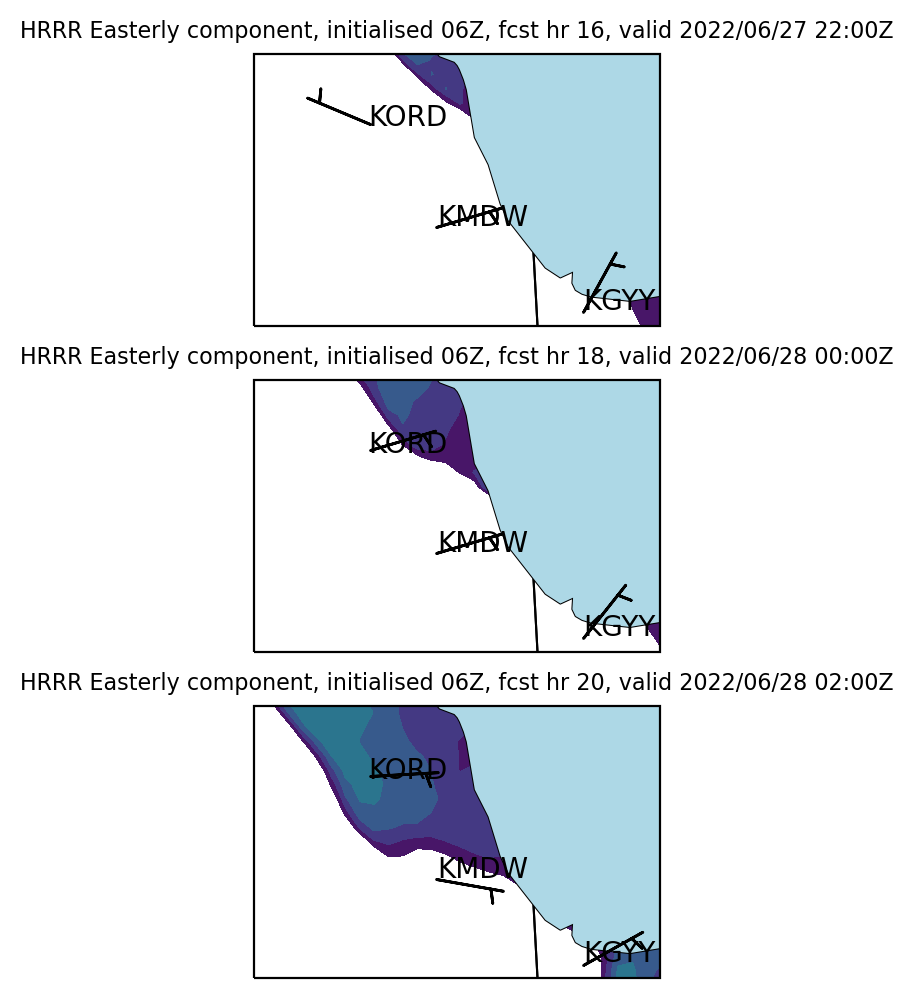

In [32]:
titles = []
# Let's form our plotting arguments.
for vt in valid_times:
    fcst_hr = int(abs(init_dt - vt).total_seconds()/3600)
    title = make_title("Easterly component",init_dt,fcst_hr=fcst_hr,valid_time=vt)
    print(title)
    titles.append(title)
# Here we go!
fig,ax = plot_contourf(ds,valid_times,titles,obs_df)

Here is a 16--20-hour forecast that gives you an idea of the lake-breeze extent during the forecast. Overlaid are the observations. Perhaps play around with the initialisation time and assess the change from run to run by eye. Again, you've got freedom to choose.

Let's look at the 12Z forecast by setting a new `init_dt` and getting the data. The preprocessing is necessary to get the data into a format to plot. (It needs even more preprocessing to work well with `metpy`. That's something you might feel comfortable exploring.)

Getting data from hrrrzarr/sfc/20220627/20220627_12z_fcst.zarr/10m_above_ground/UGRD
HRRR Easterly component, initialised 12Z, fcst hr 10, valid 2022/06/27 22:00Z
HRRR Easterly component, initialised 12Z, fcst hr 12, valid 2022/06/28 00:00Z
HRRR Easterly component, initialised 12Z, fcst hr 14, valid 2022/06/28 02:00Z
Plotting.
Plotting station KGYY
Plotting station KMDW
Plotting station KORD
Plotting.
Plotting station KGYY
Plotting station KMDW
Plotting station KORD
Plotting.
Plotting station KGYY
Plotting station KMDW
Plotting station KORD


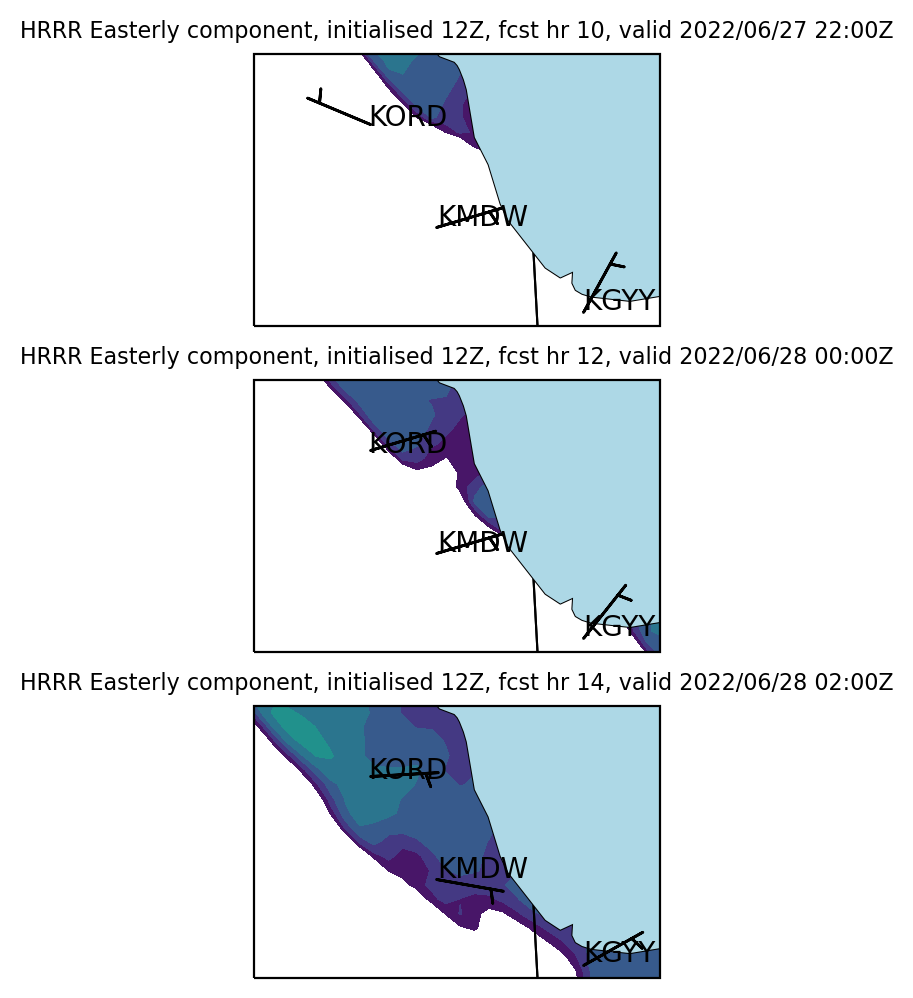

In [33]:
init_dt = datetime.datetime(2022,6,27,12,0,0)
ds = get_data(init_dt,"UGRD","10m_above_ground")
ds = preprocess_ds(ds)
titles = []
for vt in valid_times:
    fcst_hr = int(abs(init_dt - vt).total_seconds()/3600)
    title = make_title("Easterly component",init_dt,fcst_hr=fcst_hr,valid_time=vt)
    print(title)
    titles.append(title)
fig,ax = plot_contourf(ds,valid_times,titles,obs_df)

Getting data from hrrrzarr/sfc/20220627/20220627_18z_fcst.zarr/10m_above_ground/UGRD
HRRR Easterly component, initialised 18Z, fcst hr 04, valid 2022/06/27 22:00Z
HRRR Easterly component, initialised 18Z, fcst hr 06, valid 2022/06/28 00:00Z
HRRR Easterly component, initialised 18Z, fcst hr 08, valid 2022/06/28 02:00Z
Plotting.
Plotting station KGYY
Plotting station KMDW
Plotting station KORD
Plotting.
Plotting station KGYY
Plotting station KMDW
Plotting station KORD
Plotting.
Plotting station KGYY
Plotting station KMDW
Plotting station KORD


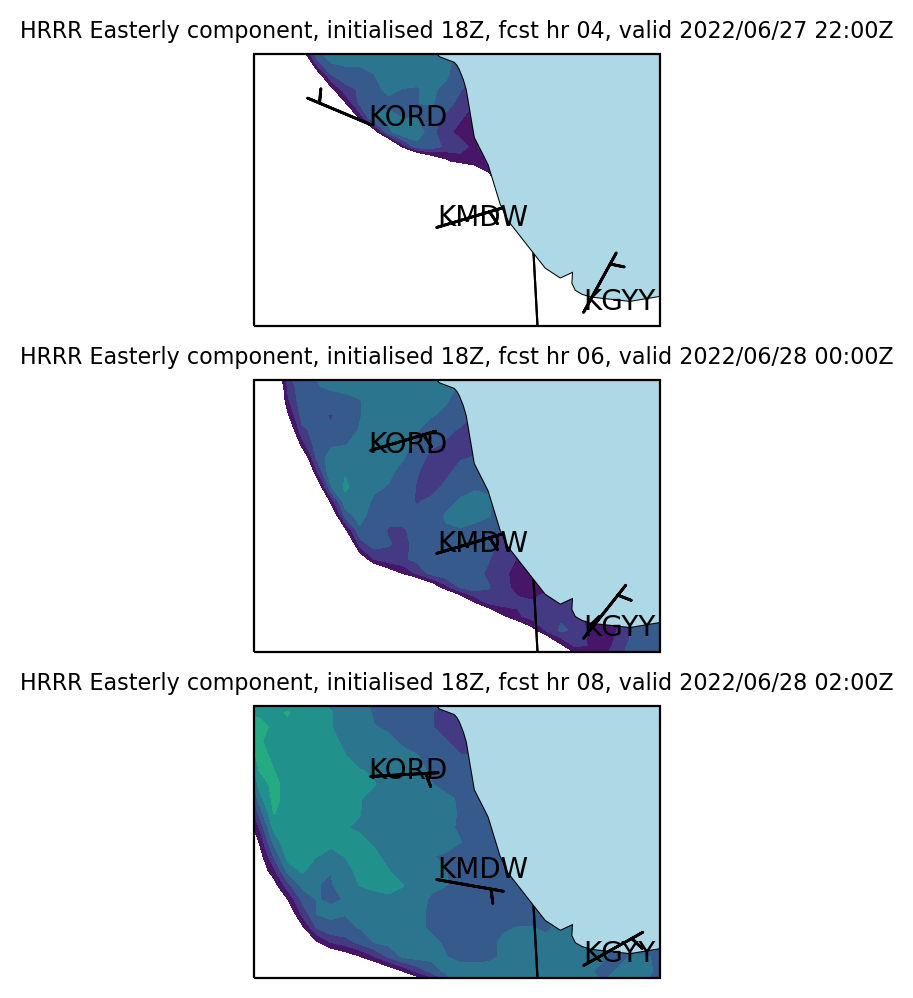

In [34]:
init_dt = datetime.datetime(2022,6,27,18,0,0)
ds = get_data(init_dt,"UGRD","10m_above_ground")
ds = preprocess_ds(ds)
titles = []
for vt in valid_times:
    fcst_hr = int(abs(init_dt - vt).total_seconds()/3600)
    title = make_title("Easterly component",init_dt,fcst_hr=fcst_hr,valid_time=vt)
    print(title)
    titles.append(title)
fig,ax = plot_contourf(ds,valid_times,titles,obs_df)

That's just a first look. Go wild! You'll have to check documentation online to see what other variables are available, or work it out via the [https://hrrrzarr.s3.amazonaws.com/index.html#sfc/20220627/20220627_12z_fcst.zarr/](repository GUI). To start you off, TMP and VGRD are 2-m temperature and 10-m dry-bulb temperature, respectively; but you'll need to set `lv` to `2m_above_ground` in the code (instead of `10m_above_ground`) to reflect the different level. Here's a code snippet for plotting observation meteograms that was previously used for wind speed, if you feel like plotting time series. There are handy functions in `metpy.calc` to convert from U/V to wind speed and wind direction, remember.

In [35]:
def plot_meteogram(times,wspd,wdir,title):
    # Hack this up and plot temperature, or different times, make it prettier...
    fig,ax1 = plt.subplots(1,figsize=(10,4))
    # ax1.plot(times,wspd,color="cyan")
    ax1.scatter(times,wdir,color="blue")
    ax1.set_ylabel("Wind direction (deg)")
    ax1.set_ylim([0,360])

    ax2 = ax1.twinx()
    ax2.plot(times,wspd,color="green")
    ax2.set_ylabel("Wind speed (m/s?)")
    ax2.set_ylim([0,5])

    ax1.xaxis.set_major_locator(HourLocator())
    ax1.xaxis.set_major_formatter(DateFormatter("%HZ"))

    ax1.set_title(title)
    return fig,ax


**Remember you can email me with problems. Reach out before it gets too late, because research is very difficult to time-manage.**